# Sine Table Generation

## Goal

This notebook contains the generation of the partial sine table used in `sin_gen`.  Ideally, we will eventually add some analysis of the numerical/spectral properties of this truncated table.  In particular, it's limited in resolution in both the temporal and amplitude dimensions (only 256 samples, with only 256 possible values each).  This will cause different sorts of artifacting at different samples-per-cycle resolutions.

There is also some spectral noise from the fact that we generate a single sine wave with each call, which leaves some phase error at the tail.  This is surfaced in the C code, so you can tell what to expect in the firmware, but it would be good to understand what kind of artifacting to expect here.

We could also update the firmware to extend the result_len by a single sample if that results in smaller phase error.  That is left for the future.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We want a 256-entry long quarter-wave of sine, bummed down to the range 128-0.  This is pretty easy:

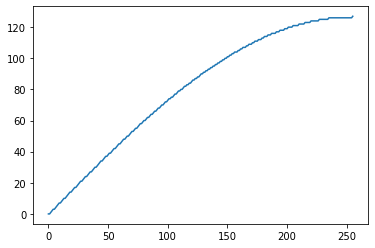

In [2]:
t = np.linspace(0, np.pi/2, 256)

# NB: we have to use 127 for scale, or we get bogus crossover at 3*pi/4 (i.e. 127-max(sin_table))
SIN_TABLE = (127 * np.sin(t)).astype(np.uint8)

plot(np.arange(0, len(t)), SIN_TABLE)

In [3]:
f = open("/tmp/sintable.c", "w")

f.write("  static const uint8_t sin_table[256] = {\n")
for i in range(16):
    f.write(" ") # Only one space to account for the loop's space
    for j in range(16*i, 16*(i+1)):
        f.write(f' {SIN_TABLE[j]:3d},')
    f.write("\n")
f.write("};")
f.close()

## Algorithm prototype: sin()

The first thing we need to do is expand this to all four quadrants.  That's pretty straigtforward: we have 256 samples in the first quadrant, which gets repeated backwards for the second quadrant.  Then we flip the sign and go forwards, and finally we go backwards through the array with a negative sign.

We also need to get the angle into our range, but we can do that by a simple modulo 1024 before this final lookup.

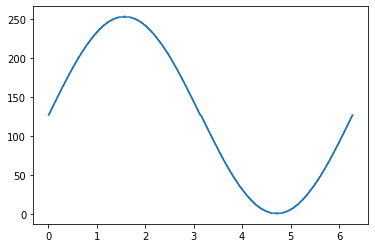

In [4]:
def sg_sin(theta):
    cursor_pos = theta * 1024/(2*np.pi)
    cursor_pos = int(cursor_pos) % 1024
    
    cursor_quadrant = cursor_pos // 256
    
    cursor_offset = cursor_pos % 256
    
    if cursor_quadrant % 2 == 1:
        cursor_offset = 255 - cursor_offset
    cursor_sign = 1 if cursor_quadrant < 2 else -1
    
    return 127+cursor_sign*SIN_TABLE[cursor_offset]


tp = np.linspace(0, 2*np.pi, 2048)

xp = np.array([ sg_sin(tp_i) for tp_i in tp ]).astype(np.uint8)
plot(tp,xp)

And a quick check of spectral purity...

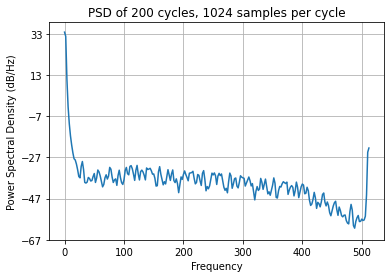

In [5]:
n_cycles = 200
samples_per_cycle = 1024
t_psd = np.linspace(0, n_cycles*np.pi, samples_per_cycle * n_cycles)
sin_psd = [ sg_sin(i)-127 for i in t_psd ] # Remove DC component

psd(sin_psd, NFFT=512, noverlap=511, Fs=samples_per_cycle);
title(f'PSD of {n_cycles} cycles, {samples_per_cycle} samples per cycle');

That looks pretty good, actually.  I'm happy with this, time to move it over to C.